In [ ]:
import pickle
import dgl
import networkx as nx

dir = './degree/BNU1_fMRI/norm_flag_no/graphs'
file = open(dir,'rb')
graphs = pickle.load(file)
print(len(graphs))

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
pd.options.mode.chained_assignment = None
%matplotlib inline

In [45]:
import dgl
from dgl.data import DGLDataset
import torch
import os

edges_fMRI = pd.read_csv('./BNU1_fMRI/fMRI_brain_graph_weighted_edges_0.8.csv')
# edges_dMRI_fused = pd.read_csv('./BNU1_dMRI/dMRI_brain_graph_edges_fused.csv')
# edges_dMRI_ses1 = pd.read_csv('./BNU1_dMRI/dMRI_brain_graph_edges_ses1.csv')
# edges_dMRI_ses2 = pd.read_csv('./BNU1_dMRI/dMRI_brain_graph_edges_ses2.csv')
properties = pd.read_csv('./BNU1_fMRI/fMRI_brain_graph_properties.csv')

edges_fMRI.head()

properties.head()

class BNU1Dataset(DGLDataset):
    def __init__(self):
        super().__init__(name='synthetic')

    def process(self):
        edges = pd.read_csv('./BNU1_fMRI/fMRI_brain_graph_weighted_edges_0.8.csv')
        properties = pd.read_csv('./BNU1_fMRI/fMRI_brain_graph_properties.csv')
        self.graphs = []
        self.labels = []

        # Create a graph for each graph ID from the edges table.
        # First process the properties table into two dictionaries with graph IDs as keys.
        # The label and number of nodes are values.
        label_dict = {}
        num_nodes_dict = {}
        for _, row in properties.iterrows():
            label_dict[row['graph_id']] = row['label']
            num_nodes_dict[row['graph_id']] = row['num_nodes']

        # For the edges, first group the table by graph IDs.
        edges_group = edges.groupby('graph_id')

        # For each graph ID...
        for graph_id in edges_group.groups:
            # Find the edges as well as the number of nodes and its label.
            edges_of_id = edges_group.get_group(graph_id)
            src = edges_of_id['src'].to_numpy()
            dst = edges_of_id['dst'].to_numpy()
            weight = edges_of_id['weight'].to_numpy()
            num_nodes = num_nodes_dict[graph_id]
            label = label_dict[graph_id]

            # Create a graph and add it to the list of graphs and labels.
            g = dgl.graph((src, dst), num_nodes=num_nodes)
            weight = torch.FloatTensor(weight)
            g.edata['weight'] = weight
            g = dgl.add_self_loop(g)
            self.graphs.append(g)
            self.labels.append(label)

        # Convert the label list to tensor for saving.
        self.labels = torch.LongTensor(self.labels)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

dataset = BNU1Dataset()
graph, label = dataset[0]
print(graph, label)

Graph(num_nodes=70, num_edges=94,
      ndata_schemes={}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)}) tensor(1)


In [69]:
import dgl.nn.pytorch as dglnn
from dgl.data.utils import split_dataset
import torch.nn as nn
import torch.nn.functional as F

class GCN_Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(GCN_Classifier, self).__init__()
        self.conv1 = dglnn.GraphConv(in_dim, hidden_dim)
        self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

class GAT_Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_heads, n_classes):
        super(GAT_Classifier, self).__init__()
        self.conv1 = dglnn.GATConv(in_dim, hidden_dim, num_heads, residual=True)
        self.conv2 = dglnn.GATConv(hidden_dim, hidden_dim, num_heads, residual=True)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

trainset, validset, testset = split_dataset(dataset, shuffle=True)
        
from dgl.dataloading import GraphDataLoader
import torch.optim as optim

Epoch 0, loss 0.7129
Epoch 1, loss 0.7120
Epoch 2, loss 0.7109
Epoch 3, loss 0.7102
Epoch 4, loss 0.7093
Epoch 5, loss 0.7084
Epoch 6, loss 0.7077
Epoch 7, loss 0.7069
Epoch 8, loss 0.7061
Epoch 9, loss 0.7054
Epoch 10, loss 0.7048
Epoch 11, loss 0.7041
Epoch 12, loss 0.7036
Epoch 13, loss 0.7029
Epoch 14, loss 0.7022
Epoch 15, loss 0.7017
Epoch 16, loss 0.7012
Epoch 17, loss 0.7007
Epoch 18, loss 0.7000
Epoch 19, loss 0.6997
Epoch 20, loss 0.6991
Epoch 21, loss 0.6987
Epoch 22, loss 0.6983
Epoch 23, loss 0.6979
Epoch 24, loss 0.6976
Epoch 25, loss 0.6972
Epoch 26, loss 0.6968
Epoch 27, loss 0.6964
Epoch 28, loss 0.6959
Epoch 29, loss 0.6956
Epoch 30, loss 0.6954
Epoch 31, loss 0.6950
Epoch 32, loss 0.6950
Epoch 33, loss 0.6947
Epoch 34, loss 0.6944
Epoch 35, loss 0.6940
Epoch 36, loss 0.6937
Epoch 37, loss 0.6937
Epoch 38, loss 0.6933
Epoch 39, loss 0.6930
Epoch 40, loss 0.6928
Epoch 41, loss 0.6927
Epoch 42, loss 0.6926
Epoch 43, loss 0.6923
Epoch 44, loss 0.6920
Epoch 45, loss 0.692

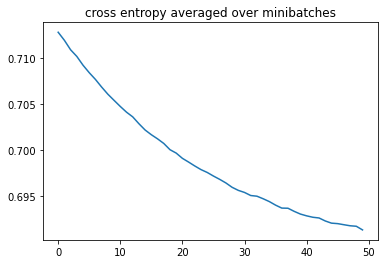

Accuracy of sampled predictions on the test set: 71.4286%
Accuracy of argmax predictions on the test set: 57.142857%


In [64]:
data_loader = GraphDataLoader(trainset, batch_size=1, shuffle=True)

model = GCN_Classifier(1, 16, 2)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.train()

epoch_losses = []
for epoch in range(50):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))